# MNIST Digit Classification Using Various Classifiers
- [Binary Classification Using SGDClassifiers](#BCSGD)
- [Binary Classification Using LogisticRegression](#BCLR)
- [Binary Classification Using RidgeClassifer](#BCRC)
- [Multi-Class Classification Using SGDClassifier (Log Loss)](#MCSGDC)
- [Multi-Class Classification Using LogisticRegression (Solvers)](#MCLR)
- [Appendix](#APPENDIX)

In [2]:
import numpy as np
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV, cross_val_predict

from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score

from scipy.stats import loguniform

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8, 6))

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

## <a id="BCSGD"></a>Binary Classification Using SGDRegressor

In [3]:
from sklearn.datasets import fetch_openml
X_pd, y_pd = fetch_openml('mnist_784', version=1, return_X_y=True)

X = X_pd.to_numpy()
y = y_pd.to_numpy()

We'll use a sigmoid function for the loss calculation here, so feature matrix should be scaled from 0 to 1.

In [41]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

print(f'Mean of the features: {np.mean(X)}')
print(f'Std.deviation: {np.std(X)}')
print(f'Minimum value: {np.min(X)}')
print(f'Maximum value: {np.max(X)}')

target_names = np.unique(y)

print(f'\nNumber of samples: {X.shape[0]}, type: {X.dtype}')
print(f'NUmber of features: {X.shape[1]}')
print(f'Number of classes: {len(target_names)}, type: {y.dtype}')
print(f'Labels: {target_names}')

Mean of the features: 0.13092720382627604
Std.deviation: 0.3084510570135976
Minimum value: 0.0
Maximum value: 1.0

Number of samples: 70000, type: float64
NUmber of features: 784
Number of classes: 10, type: object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


In [42]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

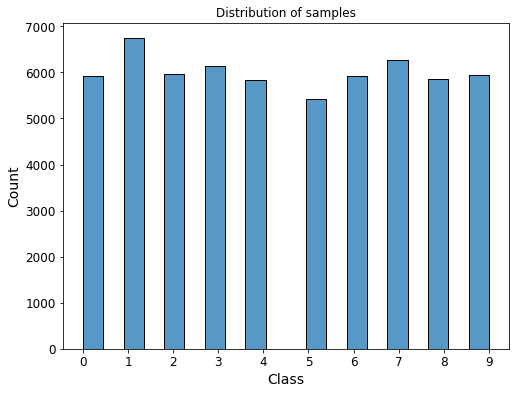

In [43]:
plt.figure()
sns.histplot(data=np.int8(y_train), binwidth=0.45, bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9], labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

In [44]:
y_train_0 = np.zeros(y_train.shape[0])
y_test_0 = np.zeros(y_test.shape[0])

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[0. 1. 0. ... 0. 0. 0.]


### Dummy (Baseline Classifier)

In [45]:
num_pos = len(np.where(y_train_0 == 0)[0])
num_neg = len(np.where(y_train_0 == 1)[0])

base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(X_train, y_train_0)
print(f'Training accuracy: {base_clf.score(X_train, y_train_0):.4f}')
print(f'Testing accuracy: {base_clf.score(X_test, y_test_0):.4f}')

Training accuracy: 0.9013
Testing accuracy: 0.9020


Reason is obvious. The model would've predicted 54077 samples correctly just by output 0 for all nput samples, Therefore, the accuracy will be 54077/60000 = 90.13%

### SGDClassifier (Log Loss)

**Training Without Regularization :** ( as `alpha` = 0 )

In [46]:
bin_sgd_clf = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

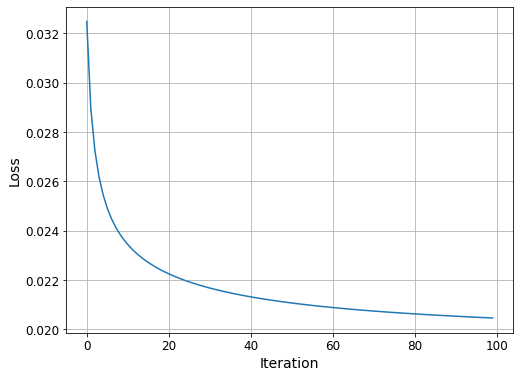

In [47]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

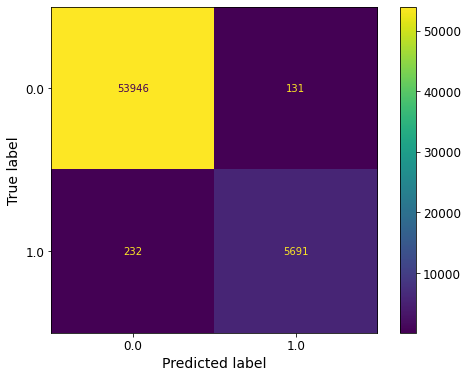

In [48]:
y_hat_train_0 = bin_sgd_clf.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [49]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     54077
         1.0       0.98      0.96      0.97      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.98      0.98     60000
weighted avg       0.99      0.99      0.99     60000



In [50]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=100, warm_start=False, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

cv_bin_clf = cross_validate(estimator, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)

pprint(cv_bin_clf)

{'estimator': [SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729),
               SGDClassifier(alpha=0, eta0=0.01, learning_rate='constant', loss='log',
              max_iter=100, random_state=1729)],
 'fit_time': array([1.16870117, 1.21506906, 1.20022583, 1.33355021, 1.17655349]),
 'score_time': array([0.03030586, 0.02695441, 0.02771854, 0.02791786, 0.02696395]),
 'test_f1': array([0.95699831, 0.954371  , 0.9616041 , 0.95870583, 0.95993252]),
 'test_precision': array([0.95538721, 0.96382429, 0.97238999, 0.96735395, 0.9

In [51]:
weights = bin_sgd_clf.coef_
bias = bin_sgd_clf.intercept_
weights.shape, bias

((1, 784), array([-4.89282893]))

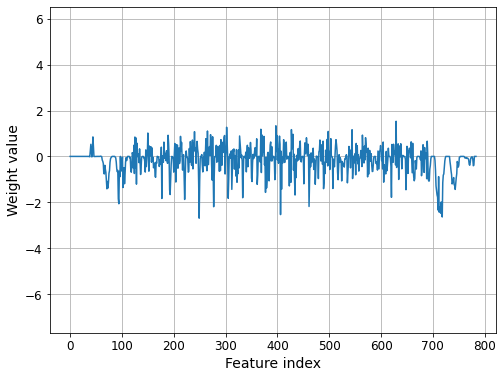

In [53]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

**Training With Regularization :**

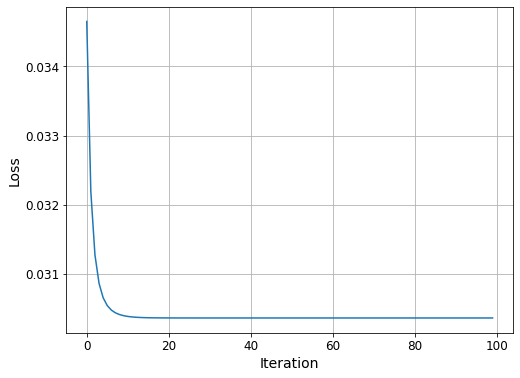

In [54]:
bin_sgd_clf_l2 = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0.001, learning_rate='constant', random_state=1729)
loss = []
iterations = 100
for i in range(iterations):
    bin_sgd_clf_l2.fit(X_train, y_train_0)
    y_pred = bin_sgd_clf_l2.predict_proba(X_train)
    loss.append(log_loss(y_train_0, y_pred))

plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

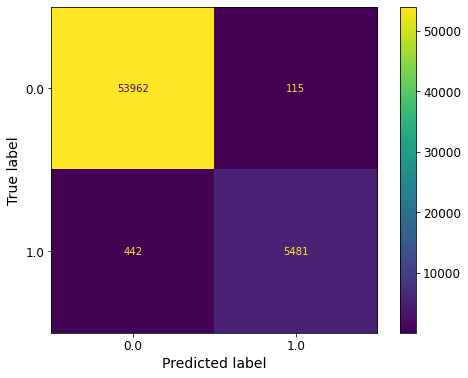

In [55]:
y_hat_train_0 = bin_sgd_clf_l2.predict(X_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='0.5g')

In [56]:
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.93      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



In [57]:
weights = bin_sgd_clf_l2.coef_
bias = bin_sgd_clf_l2.intercept_
weights.shape, bias

((1, 784), array([-4.43002876]))

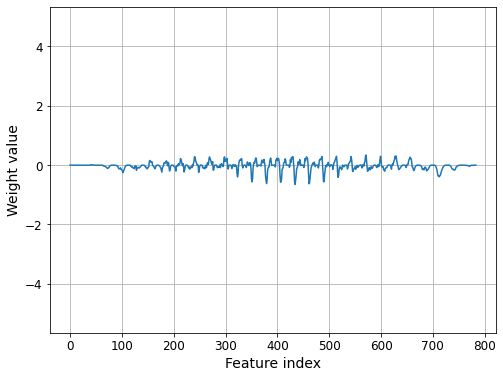

In [58]:
plt.figure()
plt.plot(np.arange(0, 784), weights[0, :])
plt.xlabel('Feature index')
plt.ylabel('Weight value')
plt.ylim(np.min(weights) - 5, np.max(weights) + 5)
plt.grid()

**Hyper Parameter Tuning :**

In [63]:
from scipy.sparse.construct import random

lr_grid = loguniform(1e-2, 1e-1)

# rvs stands for random_variables
print(lr_grid.rvs(3, random_state=42))

[0.02368864 0.0892718  0.05395031]


In [64]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)

scores = RandomizedSearchCV(estimator, param_distributions={'eta0': lr_grid}, cv=5, scoring=['precision', 'recall', 'f1'], n_iter=5, refit='f1')

scores.fit(X_train, y_train_0)

RandomizedSearchCV(cv=5,
                   estimator=SGDClassifier(alpha=0, eta0=0.01,
                                           learning_rate='constant', loss='log',
                                           max_iter=1, random_state=1729,
                                           warm_start=True),
                   n_iter=5,
                   param_distributions={'eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001F114EAC760>},
                   refit='f1', scoring=['precision', 'recall', 'f1'])

In [65]:
scores.cv_results_

{'mean_fit_time': array([0.31564913, 0.3337306 , 0.31762767, 0.34382949, 0.30816927]),
 'std_fit_time': array([0.00557493, 0.02896234, 0.00994565, 0.03724778, 0.00733884]),
 'mean_score_time': array([0.03243828, 0.02916498, 0.03180957, 0.03272228, 0.03176289]),
 'std_score_time': array([0.00527055, 0.00182743, 0.00293101, 0.00428711, 0.00356919]),
 'param_eta0': masked_array(data=[0.02368863950364078, 0.08927180304353625,
                    0.05395030966670228, 0.039687933304443715,
                    0.01432249371823025],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'eta0': 0.02368863950364078},
  {'eta0': 0.08927180304353625},
  {'eta0': 0.05395030966670228},
  {'eta0': 0.039687933304443715},
  {'eta0': 0.01432249371823025}],
 'split0_test_precision': array([0.93327909, 0.86936937, 0.90101325, 0.91304348, 0.94356846]),
 'split1_test_precision': array([0.95633562, 0.94230769, 0.94839255, 0.95068027, 0.959447

In [68]:
scores.best_estimator_

SGDClassifier(alpha=0, eta0=0.01432249371823025, learning_rate='constant',
              loss='log', max_iter=1, random_state=1729, warm_start=True)

In [69]:
y_hat_train_best_0 = scores.best_estimator_.predict(X_train)

In [70]:
print(classification_report(y_train_0, y_hat_train_best_0))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     54077
         1.0       0.98      0.92      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.99      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



## <a id="BCLR"></a>Binary Classification Using Logistic Regression

### With GridSearchCV

Training without regularization

**NOTE** : The only difference between `Pipeline()` and `make_pipeline()` is that `make_pipeline()` generates names for steps automatically. See [Appendix](#APPENDIX) to know more.

In [80]:
# C = np.infty means 0 regularization
pipe_logit = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty)) # C = np.infty means 0 regularization
pipe_logit.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('logisticregression',
                 LogisticRegression(C=inf, random_state=1729))])

**Hyper Parameter Search :**

In [81]:
from sklearn.pipeline import Pipeline

grid_Cs = [0, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10.0, 100.0]

scaler = MinMaxScaler()

logreg = LogisticRegression(C=1.0, random_state=1729) # initialized C with some value, and use grid_Cs for GridSearchCV

pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logreg)])
pipe_logit_cv = GridSearchCV(pipe, param_grid={'logistic__C': grid_Cs}, scoring='f1')
pipe_logit_cv.fit(X_train, y_train_0)

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('logistic',
                                        LogisticRegression(random_state=1729))]),
             param_grid={'logistic__C': [0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0,
                                         100.0]},
             scoring='f1')

In [82]:
print(pipe_logit_cv.best_params_)
print(pipe_logit_cv.best_score_)
print(pipe_logit_cv.best_estimator_)

{'logistic__C': 0.1}
0.9579654953103655
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('logistic', LogisticRegression(C=0.1, random_state=1729))])


### With LinearRegressionCV

In [83]:
estimator = LogisticRegressionCV(cv=5, scoring='f1', random_state=1729)
logit_cv = make_pipeline(MinMaxScaler(), estimator)
logit_cv.fit(X_train, y_train_0)

lr_y_hat_0 = pipe_logit.predict(X_test)
lr_gs_y_hat_0 = pipe_logit_cv.best_estimator_.predict(X_test)
lr_cv_y_hat_0 = logit_cv.predict(X_test)

In [84]:
precision_lr = precision_score(y_test_0, lr_y_hat_0)
recall_lr = recall_score(y_test_0, lr_y_hat_0)

precision_lr_gs = precision_score(y_test_0, lr_gs_y_hat_0)
recall_lr_gs = recall_score(y_test_0, lr_gs_y_hat_0)

precision_lr_cv = precision_score(y_test_0, lr_cv_y_hat_0)
recall_lr_cv = recall_score(y_test_0, lr_cv_y_hat_0)

print(f'LogReg: precision={precision_lr}, recall={recall_lr}')
print(f'GridSearch: precision={precision_lr_gs}, recall={recall_lr_gs}')
print(f'LogRegCV: precision={precision_lr_cv}, recall={recall_lr_cv}')

LogReg: precision=0.9515151515151515, recall=0.9612244897959183
GridSearch: precision=0.9564336372847011, recall=0.963265306122449
LogRegCV: precision=0.9546370967741935, recall=0.9663265306122449


LogisticRegression classifier obtained through `GridSearchCV` has the **highest precision.**

**NOTE :**  The `decision_function()` tells us on which side of the hyperplane generated by the classifier we are (and how far we are away from it). Based on that information, the estimator then label the examples with the corresponding label.

In [85]:
y_scores_lr = pipe_logit.decision_function(X_test)
precision_lr, recalls_lr, threshold_lr = precision_recall_curve(y_test_0, y_scores_lr)

y_scores_lr_gs = pipe_logit_cv.decision_function(X_test)
precision_lr_gs, recalls_lr_gs, threshold_lr_gs = precision_recall_curve(y_test_0, y_scores_lr_gs)

y_scores_lr_cv = logit_cv.decision_function(X_test)
precision_lr_cv, recalls_lr_cv, threshold_lr_cv = precision_recall_curve(y_test_0, y_scores_lr_cv)

### Precision-Recall Graph for Various `LogisticRegression()` Classifiers

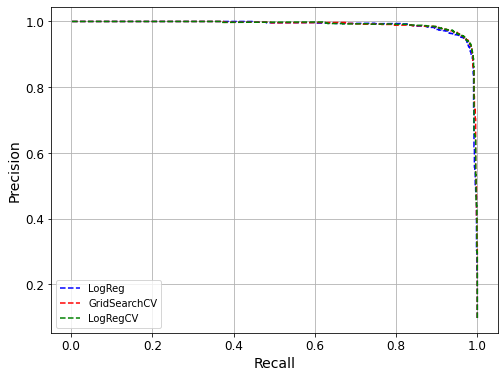

In [88]:
plt.figure()
plt.plot(recalls_lr[:-1], precision_lr[:-1], 'b--', label='LogReg')
plt.plot(recalls_lr_gs[:-1], precision_lr_gs[:-1], 'r--', label='GridSearchCV')
plt.plot(recalls_lr_cv[:-1], precision_lr_cv[:-1], 'g--', label='LogRegCV')

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)
plt.legend(loc='lower left')

### Confusion Matrix for Various `LogisticRegression()` Classifiers

**For Logistic Regression**

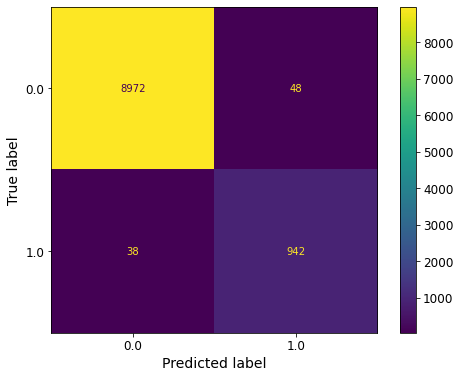

In [89]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_y_hat_0, values_format='0.5g')

**For Logistic Regression with GridSearchCV**

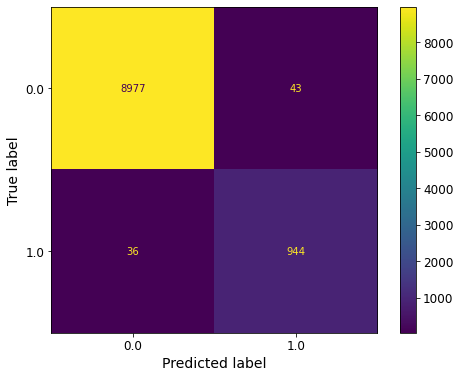

In [90]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_gs_y_hat_0, values_format='0.5g') # From GridSearchCV

**For LogisticRegressionCV**

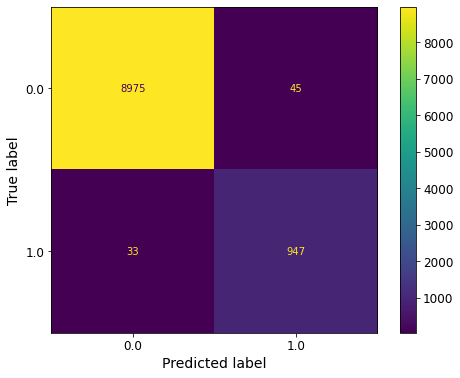

In [91]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, lr_cv_y_hat_0, values_format='0.5g') 

## <a id="BCRC"></a>Binary Classification using Ridge Classifier

In [92]:
y_train_0 = -1 * np.ones(y_train.shape[0])
y_test_0 = -1 * np.ones(y_test.shape[0])

indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

print(y_train)
print(y_train_0)

['5' '0' '4' ... '5' '6' '8']
[-1.  1. -1. ... -1. -1. -1.]


In [93]:
estimator = RidgeClassifier(normalize=False, alpha=0) # No regularization
pipe_ridge = make_pipeline(MinMaxScaler(), estimator)
pipe_ridge.fit(X_train, y_train_0)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])

In [94]:
y_hat_test_0 = pipe_ridge.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.96      0.89      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000



In [95]:
cv_bin_ridge_clf = cross_validate(pipe_ridge, X_train, y_train_0, cv=5, scoring=['precision', 'recall', 'f1'], return_train_score=True, return_estimator=True)
pprint(cv_bin_ridge_clf)

{'estimator': [Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))]),
               Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('ridgeclassifier', RidgeClassifier(alpha=0, normalize=False))])],
 'fit_time': array([5.16514421, 5.15254688, 4.98605967, 4.98292089, 4.99014163]),
 'score_time': array([0.08016777, 0.07255554, 0.08656764, 0.08307362, 0.08384347]),
 'test_f1': array([0.90319716, 0.90845379, 0.92164675, 0.89788574, 0.90559284]),
 'test_precision'

In [96]:
best_estimator_id = np.argmax(cv_bin_ridge_clf['train_f1'])
print(best_estimator_id)

best_estimator = cv_bin_ridge_clf['estimator'][best_estimator_id]

y_hat_test_0 = best_estimator.predict(X_test)
print(classification_report(y_test_0, y_hat_test_0))

2
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99      9020
         1.0       0.96      0.89      0.92       980

    accuracy                           0.98     10000
   macro avg       0.97      0.94      0.96     10000
weighted avg       0.98      0.98      0.98     10000



## <a id="MCSGDC"></a>Multiclass SGDClassifier (Log Loss)

### Multi Class Classification Procedure

Similar procedure as `SGDClassifier()` but instead of training the transformed data (0 is mapped 1 and everything else is mapped to 0 i.e with 2 labels), **we train the model on the entire raw data with all the labels** (here, the one with 10 labels)

In [97]:
estimator = SGDClassifier(loss='log', penalty='l2', max_iter=1, warm_start=True, eta0=0.01, alpha=0, learning_rate='constant', random_state=1729)
pipe_sgd_ovr = make_pipeline(MinMaxScaler(), estimator)

loss = []
iterations = 100
for i in range(iterations):
    pipe_sgd_ovr.fit(X_train, y_train)  # Train on all classes
    y_pred = pipe_sgd_ovr.predict_proba(X_train)
    loss.append(log_loss(y_train, y_pred))

Text(0, 0.5, 'Loss')

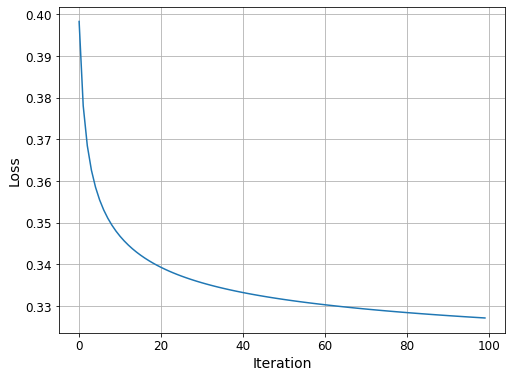

In [98]:
plt.figure()
plt.plot(np.arange(iterations), loss)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [99]:
y_hat = pipe_sgd_ovr.predict(X_test)

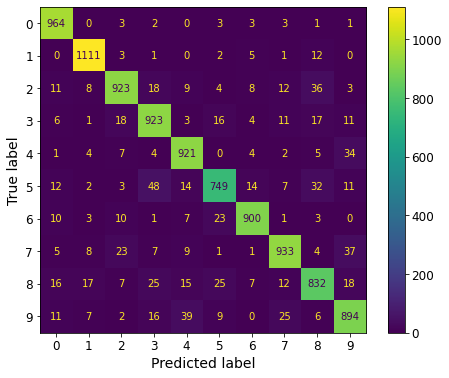

In [100]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [101]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.92      0.89      0.91      1032
           3       0.88      0.91      0.90      1010
           4       0.91      0.94      0.92       982
           5       0.90      0.84      0.87       892
           6       0.95      0.94      0.95       958
           7       0.93      0.91      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.89      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.92      0.91     10000



## <a id="MCLR"></a>Multiclass LogisticRegression (Solvers)

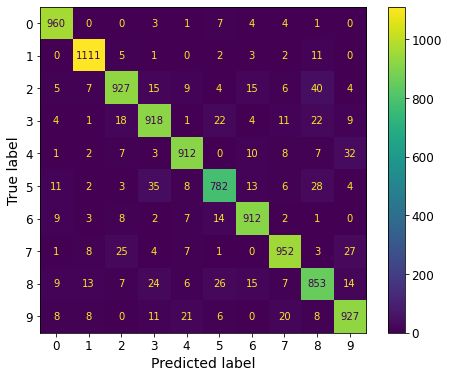

In [103]:
# C=np.infty indicates no regularization
pipe_logit_ovr = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1729, solver='lbfgs', C=np.infty))  
pipe_logit_ovr.fit(X_train, y_train)


y_hat = pipe_logit_ovr.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_hat, values_format='0.5g')

In [104]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.90      0.91      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.88      0.89       892
           6       0.93      0.95      0.94       958
           7       0.94      0.93      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



## <a id="APPENDIX"></a>Appendix

**1. The difference between `Pipeline()` and `make_pipeline()` :**

- **`Pipeline()` :**
    - Names are explicit, you don't have to figure them out if you need them;
    - Name doesn't change if you change estimator/transformer used in a step, e.g. if you replace LogisticRegression() with LinearSVC() you can still use clf__C.

- **`make_pipeline() :`**
    - Shorter and arguably more readable notation;
    - Names are auto-generated using a straightforward rule (lowercase name of an estimator).


For example :

```
pipe = Pipeline([('vec', CountVectorizer()), ('clf', LogisticRegression()])
param_grid = [{'clf__C': [1, 10, 100, 1000]}
gs = GridSearchCV(pipe, param_grid)
gs.fit(X, y)
```

compare it with make_pipeline:

```
pipe = make_pipeline(CountVectorizer(), LogisticRegression())     
param_grid = [{'logisticregression__C': [1, 10, 100, 1000]}
gs = GridSearchCV(pipe, param_grid)
gs.fit(X, y)
```